In [187]:
import scipy.stats as st
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
import sklearn.preprocessing
import sklearn.pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
gpu = pd.read_json(open("./gpu_data.json"))

In [3]:
gpu

,name,cfg,memtype,buswidth,coreclk,memclk
0,3D Rage II,"[1, 1, 1]",SDR,64,60,83
1,3D Rage II+ DVD,"[1, 1, 1]",SDR,64,60,83
2,3D Rage IIC AGP,"[1, 1, 1]",SDR,64,60,83
3,3D Rage IIC PCI,"[1, 1, 1]",SDR,64,60,83
4,3D Rage PRO AGP,"[1, 1, 1]",SDR,64,75,75
...,...,...,...,...,...,...
2358,Xeon Phi 5120D,"[960, 32, 0]",GDDR5,512,1053,1250
2359,Xeon Phi 7120P,"[976, 32, 0]",GDDR5,512,1238,1375
2360,Xeon Phi 7120X,"[976, 32, 0]",GDDR5,512,1238,1375
2361,Xeon Phi SE10X,"[976, 32, 0]",GDDR5,512,1100,1375


In [4]:
gpu["Shaders"] = [i[0] for i in gpu["cfg"]]
gpu["TMU"] = [i[1] for i in gpu["cfg"]]
gpu["ROP"] = [i[2] for i in gpu["cfg"]]
gpu = gpu[["name","Shaders","TMU","ROP","memtype","buswidth","coreclk","memclk"]]

In [5]:
gpu

,name,Shaders,TMU,ROP,memtype,buswidth,coreclk,memclk
0,3D Rage II,1,1,1,SDR,64,60,83
1,3D Rage II+ DVD,1,1,1,SDR,64,60,83
2,3D Rage IIC AGP,1,1,1,SDR,64,60,83
3,3D Rage IIC PCI,1,1,1,SDR,64,60,83
4,3D Rage PRO AGP,1,1,1,SDR,64,75,75
...,...,...,...,...,...,...,...,...
2358,Xeon Phi 5120D,960,32,0,GDDR5,512,1053,1250
2359,Xeon Phi 7120P,976,32,0,GDDR5,512,1238,1375
2360,Xeon Phi 7120X,976,32,0,GDDR5,512,1238,1375
2361,Xeon Phi SE10X,976,32,0,GDDR5,512,1100,1375


In [6]:
gpu.loc[gpu["memtype"] == " SDR","memtype_mult"] = 1
gpu.loc[gpu["memtype"] == " DDR","memtype_mult"] = 2
gpu.loc[gpu["memtype"] == " DDR2","memtype_mult"] = 2
gpu.loc[gpu["memtype"] == " GDDR2","memtype_mult"] = 2
gpu.loc[gpu["memtype"] == " DDR3","memtype_mult"] = 2
gpu.loc[gpu["memtype"] == " GDDR3","memtype_mult"] = 2
gpu.loc[gpu["memtype"] == " HBM","memtype_mult"] = 2
gpu.loc[gpu["memtype"] == " HBM2","memtype_mult"] = 2
gpu.loc[gpu["memtype"] == " GDDR5","memtype_mult"] = 4
gpu.loc[gpu["memtype"] == " LPDDR5","memtype_mult"] = 4
gpu.loc[gpu["memtype"] == " GDDR5X","memtype_mult"] = 8
gpu.loc[gpu["memtype"] == " GDDR6","memtype_mult"] = 8
gpu.loc[gpu["memtype"] == " GDDR6X","memtype_mult"] = 16

In [7]:
gpu["TFLOPS"] = gpu["Shaders"] * gpu["coreclk"] * 2 / 1000000
gpu["GTx/s"] = gpu["TMU"] * gpu["coreclk"] / 1000
gpu["GPx/s"] = gpu["ROP"] * gpu["coreclk"] / 1000
gpu["Bandwidth"] = gpu["memclk"]*gpu["buswidth"]*gpu["memtype_mult"]/8000

In [8]:
gpu.sort_values("TFLOPS")

,name,Shaders,TMU,ROP,memtype,buswidth,coreclk,memclk,memtype_mult,TFLOPS,GTx/s,GPx/s,Bandwidth
0,3D Rage II,1,1,1,SDR,64,60,83,1.0,0.00012,0.06,0.06,0.664
1,3D Rage II+ DVD,1,1,1,SDR,64,60,83,1.0,0.00012,0.06,0.06,0.664
2,3D Rage IIC AGP,1,1,1,SDR,64,60,83,1.0,0.00012,0.06,0.06,0.664
3,3D Rage IIC PCI,1,1,1,SDR,64,60,83,1.0,0.00012,0.06,0.06,0.664
13,All-In-Wonder 3D Rage II+ DVD,1,1,1,SDR,64,60,83,1.0,0.00012,0.06,0.06,0.664
...,...,...,...,...,...,...,...,...,...,...,...,...,...
909,GeForce RTX 4080,9728,304,112,GDDR6X,256,2205,1400,16.0,42.90048,670.32,246.96,716.800
913,GeForce RTX 4080 Ti,14080,440,144,GDDR6X,320,2100,1325,16.0,59.13600,924.00,302.40,848.000
914,GeForce RTX 4090,16384,512,176,GDDR6X,384,2235,1313,16.0,73.23648,1144.32,393.36,1008.384
2302,TITAN Ada,18432,576,192,GDDR6X,384,2235,1500,16.0,82.39104,1287.36,429.12,1152.000


In [9]:
gpu.loc[gpu["name"].str.contains("GeForce"),"Make"] = "Nvidia"
gpu.loc[gpu["name"].str.contains("TITAN"),"Make"] = "Nvidia"
gpu.loc[gpu["name"].str.contains("Quadro"),"Make"] = "Nvidia"
gpu.loc[gpu["name"].str.contains("Radeon HD"),"Make"] = "AMD"
gpu.loc[gpu["name"].str.contains("Radeon RX"),"Make"] = "AMD"
gpu.loc[gpu["name"].str.contains("Radeon R\d"),"Make"] = "AMD"
gpu.loc[gpu["name"].str.contains("Rage"),"Make"] = "ATI"
gpu.loc[gpu["name"].str.contains("Xeon"),"Make"] = "Intel"
gpu.loc[gpu["name"].str.contains("ARC"),"Make"] = "Intel"
gpu.loc[gpu["name"].str.contains("Arc"),"Make"] = "Intel"

In [10]:
gpu.loc[gpu["name"].str.contains("GTX 7"),"Architecture"] = "Kepler"
gpu.loc[gpu["name"].str.contains("GTX 9"),"Architecture"] = "Maxwell"
gpu.loc[gpu["name"].str.contains("GT 9"),"Architecture"] = "Maxwell"
gpu.loc[gpu["name"].str.contains("GTX 10"),"Architecture"] = "Pascal"
gpu.loc[gpu["name"].str.contains("GT 10"),"Architecture"] = "Pascal"
gpu.loc[gpu["name"].str.contains("GTX 16"),"Architecture"] = "Turing"
gpu.loc[gpu["name"].str.contains("RTX 20"),"Architecture"] = "Turing"
gpu.loc[gpu["name"].str.contains("RTX 30"),"Architecture"] = "Ampere"
gpu.loc[gpu["name"].str.contains("RTX 40"),"Architecture"] = "Ada"
gpu.loc[gpu["name"].str.contains("R\d 2"),"Architecture"] = "GCN 2"
gpu.loc[gpu["name"].str.contains("R\d 3"),"Architecture"] = "GCN 3"
gpu.loc[gpu["name"].str.contains("RX 4..$"),"Architecture"] = "GCN 4"
gpu.loc[gpu["name"].str.contains("RX 5\d0$"),"Architecture"] = "GCN 4"
gpu.loc[gpu["name"].str.contains("RX 5\d0 "),"Architecture"] = "GCN 4"
gpu.loc[gpu["name"].str.contains("RX Vega "),"Architecture"] = "GCN 5"
gpu.loc[gpu["name"].str.contains("RX 5..0"),"Architecture"] = "RDNA 1"
gpu.loc[gpu["name"].str.contains("RX 6..."),"Architecture"] = "RDNA 2"
gpu.loc[gpu["name"].str.contains("RX 7..."),"Architecture"] = "RDNA 3"
gpu.loc[gpu["name"].str.contains("Arc A"),"Architecture"] = "Alchemist"

In [11]:
multidx = list(zip(gpu["Make"],gpu["name"]))
multidx = pd.MultiIndex.from_tuples(multidx)

In [12]:
multidx

MultiIndex([(  'ATI',             '3D Rage II'),
            (  'ATI',        '3D Rage II+ DVD'),
            (  'ATI',        '3D Rage IIC AGP'),
            (  'ATI',        '3D Rage IIC PCI'),
            (  'ATI',        '3D Rage PRO AGP'),
            (  'ATI',        '3D Rage PRO PCI'),
            (    nan,                     'A2'),
            (    nan,                'A2 PCIe'),
            (    nan,               'A10 PCIe'),
            (    nan,                   'A10G'),
            ...
            (    nan,         'Xbox One X GPU'),
            (    nan,      'Xbox Series S GPU'),
            (    nan,      'Xbox Series X GPU'),
            ('Intel',         'Xeon Phi 3120A'),
            ('Intel',         'Xeon Phi 5110P'),
            ('Intel',         'Xeon Phi 5120D'),
            ('Intel',         'Xeon Phi 7120P'),
            ('Intel',         'Xeon Phi 7120X'),
            ('Intel',         'Xeon Phi SE10X'),
            (    nan, 'Zhongshan Subor Z+ GPU')],
   

In [13]:
gpu = gpu.set_index(multidx)

In [14]:
gpu.loc[pd.NA]

,name,Shaders,TMU,ROP,memtype,buswidth,coreclk,memclk,memtype_mult,TFLOPS,GTx/s,GPx/s,Bandwidth,Make,Architecture
A2,A2,1280,40,32,GDDR6,128,1440,1563,8.0,3.686400,57.600,46.080,200.064,NaN,NaN
A2 PCIe,A2 PCIe,1280,40,32,GDDR6,128,1440,1563,8.0,3.686400,57.600,46.080,200.064,NaN,NaN
A10 PCIe,A10 PCIe,9216,288,96,GDDR6,384,885,1563,8.0,16.312320,254.880,84.960,600.192,NaN,NaN
A10G,A10G,9216,288,96,GDDR6,384,1320,1563,8.0,24.330240,380.160,126.720,600.192,NaN,NaN
A16 PCIe,A16 PCIe,1280,40,32,GDDR6,128,1312,1563,8.0,3.358720,52.480,41.984,200.064,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xbox One S GPU,Xbox One S GPU,768,48,16,DDR3,256,914,1066,2.0,1.403904,43.872,14.624,68.224,NaN,NaN
Xbox One X GPU,Xbox One X GPU,2560,160,32,GDDR5,384,1172,1700,4.0,6.000640,187.520,37.504,326.400,NaN,NaN
Xbox Series S GPU,Xbox Series S GPU,1280,80,32,GDDR6,128,1565,1750,8.0,4.006400,125.200,50.080,224.000,NaN,NaN
Xbox Series X GPU,Xbox Series X GPU,3328,208,64,GDDR6,320,1825,1750,8.0,12.147200,379.600,116.800,560.000,NaN,NaN


In [15]:
gpu.index.names = ["Make","Name"]
gpu.drop(["name","Make"],axis=1,inplace=True)

In [16]:
benchmarks = pd.read_csv("GPU_benchmarks_v7.csv")

In [17]:
benchmarks

,gpuName,G3Dmark,G2Dmark,price,gpuValue,TDP,powerPerformance,testDate,category
0,GeForce RTX 3090 Ti,29094,1117,2099.99,13.85,450.0,64.65,2022,Unknown
1,GeForce RTX 3080 Ti,26887,1031,1199.99,22.41,350.0,76.82,2021,Desktop
2,GeForce RTX 3090,26395,999,1749.99,15.08,350.0,75.41,2020,Desktop
3,Radeon RX 6900 XT,25458,1102,1120.31,22.72,300.0,84.86,2020,Desktop
4,GeForce RTX 3080,24853,1003,999.00,24.88,320.0,77.66,2020,Desktop
...,...,...,...,...,...,...,...,...,...
2312,Intel 82852/82855 GM/GME Controller,1,107,NaN,NaN,NaN,NaN,2010,Unknown
2313,Quadro2 Pro,1,143,NaN,NaN,NaN,NaN,2009,Workstation
2314,Rage 128 Pro,1,40,NaN,NaN,NaN,NaN,2009,Unknown
2315,RAGE 128 PRO AGP 4X TMDS,1,142,NaN,NaN,NaN,NaN,2009,Unknown


In [18]:
benchmarks["Name"] = benchmarks["gpuName"]
benchmarks = benchmarks.set_index(benchmarks["Name"])
benchmarks.drop("gpuName", axis=1, inplace=True)
benchmarks.drop("Name", axis=1, inplace=True)
benchmarks = benchmarks["G3Dmark"]

In [19]:
benchmarks

Name
GeForce RTX 3090 Ti                    29094
GeForce RTX 3080 Ti                    26887
GeForce RTX 3090                       26395
Radeon RX 6900 XT                      25458
GeForce RTX 3080                       24853
                                       ...  
Intel 82852/82855 GM/GME Controller        1
Quadro2 Pro                                1
Rage 128 Pro                               1
RAGE 128 PRO AGP 4X TMDS                   1
S3 ProSavageDDR                            1
Name: G3Dmark, Length: 2317, dtype: int64

In [20]:
merged = pd.merge(gpu, benchmarks, on="Name")

In [21]:
merged

,Shaders,TMU,ROP,memtype,buswidth,coreclk,memclk,memtype_mult,TFLOPS,GTx/s,GPx/s,Bandwidth,Architecture,G3Dmark
Name,,,,,,,,,,,,,,
FireGL V3100,6,4,4,DDR,64,391,196,2.0,0.004692,1.564,1.564,3.136,NaN,53
FireGL V3200,6,4,4,DDR,128,500,350,2.0,0.006000,2.000,2.000,11.200,NaN,85
FireGL V3300,6,4,4,DDR2,64,600,400,2.0,0.007200,2.400,2.400,6.400,NaN,71
FireGL V3350,6,4,4,DDR2,64,600,400,2.0,0.007200,2.400,2.400,6.400,NaN,69
FireGL V3400,17,4,4,GDDR3,128,500,500,2.0,0.017000,2.000,2.000,16.000,NaN,103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tesla T4,2560,160,64,GDDR6,256,585,1250,8.0,2.995200,93.600,37.440,320.000,NaN,11113
TITAN RTX,4608,288,96,GDDR6,384,1350,1750,8.0,12.441600,388.800,129.600,672.000,NaN,20169
TITAN V,5120,320,96,HBM2,3072,1200,848,2.0,12.288000,384.000,115.200,651.264,NaN,18816


In [22]:
# Manually inputting boost clocks (temporary solution)
# merged["coreclk"] = [1200,1050,1180,1400,1250,1250,1150,1815,1150,1800,920,1400,1800,1000,1800,1000,1150,1150,1050,1020,1875,1250,1050,1350,2321,1330,1800,1300,1000,1850,1400,1430,1550,2850,1350,1875,1875,1550,1850,1890,2400,1750,1600,1850,2500,1950,1750,2400,1860,1875,2000,1900,1750,2600,1750,2700,1900,1900,1900,1850,2600,2200,1900,1800,2350,1900,2500,1900,1900,1850,2550,1900,1950,2650,2650]
# merged["TFLOPS"] = merged["Shaders"] * merged["coreclk"] * 2 / 1000000
# merged["GTx/s"] = merged["TMU"] * merged["coreclk"] / 1000
# merged["GPx/s"] = merged["ROP"] * merged["coreclk"] / 1000

In [23]:
merged.groupby("Architecture").count()

,Shaders,TMU,ROP,memtype,buswidth,coreclk,memclk,memtype_mult,TFLOPS,GTx/s,GPx/s,Bandwidth,G3Dmark
Architecture,,,,,,,,,,,,,
Ada,1,1,1,1,1,1,1,1,1,1,1,1,1
Ampere,7,7,7,7,7,7,7,7,7,7,7,7,7
GCN 2,14,14,14,14,14,14,14,14,14,14,14,14,14
GCN 3,7,7,7,7,7,7,7,7,7,7,7,7,7
GCN 4,7,7,7,7,7,7,7,7,7,7,7,7,7
GCN 5,4,4,4,4,4,4,4,4,4,4,4,4,4
Kepler,12,12,12,12,12,12,12,12,12,12,12,12,12
Maxwell,12,12,12,12,12,12,12,12,12,12,12,12,12
Pascal,7,7,7,7,7,7,7,7,7,7,7,7,7


In [24]:
reduced = merged[merged["Architecture"].notna()]
reduced = reduced[["TFLOPS","GTx/s","GPx/s","Bandwidth","Architecture","G3Dmark"]]

In [25]:
reduced.sort_values("Architecture")

,TFLOPS,GTx/s,GPx/s,Bandwidth,Architecture,G3Dmark
Name,,,,,,
Quadro RTX 4000,4.63104,144.72,64.32,416.000,Ada,15515
GeForce RTX 3060 Ti,13.71648,214.32,112.80,448.000,Ampere,20206
GeForce RTX 3070 Ti,19.35360,302.40,151.20,608.256,Ampere,23367
GeForce RTX 3080,25.06752,391.68,138.24,760.320,Ampere,24853
GeForce RTX 3080 Ti,27.95520,436.80,152.88,912.384,Ampere,26887
...,...,...,...,...,...,...
GeForce GTX 1660 SUPER,4.30848,134.64,73.44,336.000,Turing,12732
GeForce GTX 1660 Ti,4.60800,144.00,72.00,288.000,Turing,11794
GeForce RTX 2060,5.24160,163.80,65.52,336.000,Turing,13953


In [26]:
reduced.drop(reduced.loc[reduced.index.str.contains("RX .*M")].index,inplace=True)
reduced.drop(reduced.loc[reduced.index.str.contains(".*S")].index,inplace=True)
reduced.drop(reduced.loc[reduced.index.str.contains(".*A")].index,inplace=True)

In [27]:
reduced

,TFLOPS,GTx/s,GPx/s,Bandwidth,Architecture,G3Dmark
Name,,,,,,
GeForce GT 1030,0.943104,29.472,19.648,48.064,Pascal,2545
GeForce GTX 750,1.044480,32.640,16.320,80.192,Kepler,3399
GeForce GTX 750 Ti,1.305600,40.800,16.320,86.400,Kepler,3919
GeForce GTX 760,2.257920,94.080,31.360,192.256,Kepler,4775
GeForce GTX 760 Ti OEM,2.459520,102.480,29.280,192.256,Kepler,5427
...,...,...,...,...,...,...
Radeon RX 6800,13.056000,408.000,163.200,512.000,RDNA 2,20667
Radeon RX 6800 XT,16.819200,525.600,233.600,512.000,RDNA 2,23364
Radeon RX 6900 XT,18.688000,584.000,233.600,512.000,RDNA 2,25458


In [28]:
enc = sklearn.preprocessing.OrdinalEncoder(categories=[["Kepler","GCN 2","GCN 3","Maxwell","GCN 4","GCN 5","Pascal","Turing","RDNA 1","RDNA 2","Ampere","Ada"]])
reduced["Architecture"] = enc.fit_transform(reduced["Architecture"].array.reshape(-1,1))

In [29]:
reduced

,TFLOPS,GTx/s,GPx/s,Bandwidth,Architecture,G3Dmark
Name,,,,,,
GeForce GT 1030,0.943104,29.472,19.648,48.064,6.0,2545
GeForce GTX 750,1.044480,32.640,16.320,80.192,0.0,3399
GeForce GTX 750 Ti,1.305600,40.800,16.320,86.400,0.0,3919
GeForce GTX 760,2.257920,94.080,31.360,192.256,0.0,4775
GeForce GTX 760 Ti OEM,2.459520,102.480,29.280,192.256,0.0,5427
...,...,...,...,...,...,...
Radeon RX 6800,13.056000,408.000,163.200,512.000,9.0,20667
Radeon RX 6800 XT,16.819200,525.600,233.600,512.000,9.0,23364
Radeon RX 6900 XT,18.688000,584.000,233.600,512.000,9.0,25458


In [30]:
zeroes = pd.DataFrame()
zeroes["TFLOPS"] = [0 for i in range(12)]
zeroes["GTx/s"] = [0 for i in range(12)]
zeroes["GPx/s"] = [0 for i in range(12)]
zeroes["Bandwidth"] = [0 for i in range(12)]
zeroes["Architecture"] = [i for i in range(12)]
zeroes["G3Dmark"] = [0 for i in range(12)]
zeroes.index = ["a","b","c","d","e","f","g","h","i","j","k","l"]

In [31]:
reduced = pd.concat([reduced,zeroes])

<Axes: >

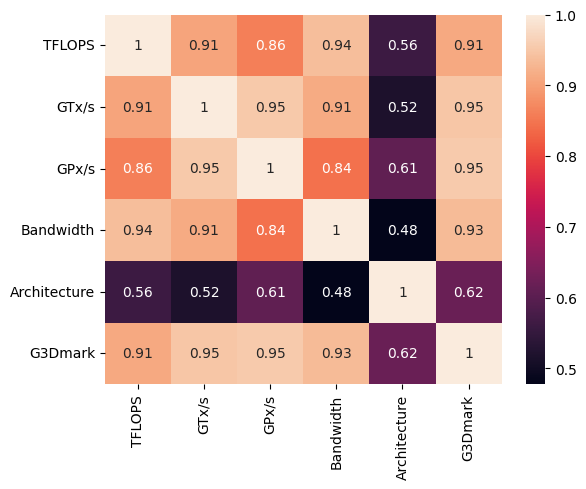

In [32]:
sns.heatmap(reduced.corr(),annot=True)

In [33]:
#sns.pairplot(reduced)

In [34]:
x = reduced.copy()
y = x.pop("G3Dmark")

In [185]:
es=EarlyStopping(mode="min",patience=20, verbose=1)

In [36]:
minmae = 99999
maetest = []
maxscore = -9999
scoretest = [] 
for i in np.arange(1,2001,499):
    kf = KFold(n_splits=6, shuffle=True, random_state=i)
    regression = sklearn.linear_model.LinearRegression()
    mmscale = sklearn.preprocessing.MinMaxScaler()
    for train, test in kf.split(x):
        x_train,x_test,y_train, y_test = x.iloc[train], x.iloc[test], y[train], y[test]
        x_train = mmscale.fit_transform(x_train)
        x_test = mmscale.transform(x_test)
 
        model = Sequential()

        model.add(Dense(5,activation="relu"))
        model.add(Dense(4,activation="relu"))
        model.add(Dense(3,activation="relu"))
        model.add(Dense(3,activation="relu"))
        model.add(Dense(1))

        model.compile(optimizer="adam", loss="mae")
        model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=1000,callbacks=[es],batch_size=16,verbose=2)
        mae = mean_absolute_error(y_test,model.predict(x_test))
        score = model.evaluate(x_test, y_test)
    if mae<minmae:
        minmae = mae
        maetest = test
    if score>maxscore:
        maxscore = score
        scoretest = test
print(f"Minimum MAE of {minmae} was achieved with set {maetest}\n Maximum score of {maxscore} was achieved with {scoretest}")

Epoch 1/1000
5/5 - 1s - loss: 8433.2412 - val_loss: 10863.9229 - 521ms/epoch - 104ms/step
Epoch 2/1000
5/5 - 0s - loss: 8433.2217 - val_loss: 10863.9023 - 29ms/epoch - 6ms/step
Epoch 3/1000
5/5 - 0s - loss: 8433.2041 - val_loss: 10863.8809 - 28ms/epoch - 6ms/step
Epoch 4/1000
5/5 - 0s - loss: 8433.1846 - val_loss: 10863.8584 - 35ms/epoch - 7ms/step
Epoch 5/1000
5/5 - 0s - loss: 8433.1650 - val_loss: 10863.8340 - 30ms/epoch - 6ms/step
Epoch 6/1000
5/5 - 0s - loss: 8433.1445 - val_loss: 10863.8105 - 30ms/epoch - 6ms/step
Epoch 7/1000
5/5 - 0s - loss: 8433.1221 - val_loss: 10863.7842 - 29ms/epoch - 6ms/step
Epoch 8/1000
5/5 - 0s - loss: 8433.0996 - val_loss: 10863.7568 - 28ms/epoch - 6ms/step
Epoch 9/1000
5/5 - 0s - loss: 8433.0752 - val_loss: 10863.7266 - 28ms/epoch - 6ms/step
Epoch 10/1000
5/5 - 0s - loss: 8433.0488 - val_loss: 10863.6973 - 28ms/epoch - 6ms/step
Epoch 11/1000
5/5 - 0s - loss: 8433.0234 - val_loss: 10863.6641 - 28ms/epoch - 6ms/step
Epoch 12/1000
5/5 - 0s - loss: 8432.99

In [198]:
train = list(range(len(x)))
test = [0,1,4,6,7,31,38,41,61,63,74,77,83,85,86,91]
for i in test: 
    train.remove(i)
x_train,x_test,y_train, y_test = x.iloc[train], x.iloc[test], y[train], y[test]
x_train = mmscale.fit_transform(x_train)
x_test = mmscale.transform(x_test)

In [229]:
model = Sequential()

model.add(Dense(5,activation="relu"))
model.add(Dense(4,activation="relu"))
model.add(Dense(3,activation="relu"))
model.add(Dense(3,activation="relu"))
model.add(Dense(1))

model.compile(optimizer="adam", loss="mae")

In [230]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=1500,callbacks=[es],batch_size=16)

Epoch 1/1500
5/5 [==============================] - 0s 24ms/step - loss: 8852.6680 - val_loss: 8767.1250
Epoch 2/1500
5/5 [==============================] - 0s 6ms/step - loss: 8852.6592 - val_loss: 8767.1191
Epoch 3/1500
5/5 [==============================] - 0s 7ms/step - loss: 8852.6514 - val_loss: 8767.1133
Epoch 4/1500
5/5 [==============================] - 0s 7ms/step - loss: 8852.6455 - val_loss: 8767.1084
Epoch 5/1500
5/5 [==============================] - 0s 7ms/step - loss: 8852.6396 - val_loss: 8767.1035
Epoch 6/1500
5/5 [==============================] - 0s 8ms/step - loss: 8852.6318 - val_loss: 8767.0977
Epoch 7/1500
5/5 [==============================] - 0s 7ms/step - loss: 8852.6260 - val_loss: 8767.0928
Epoch 8/1500
5/5 [==============================] - 0s 6ms/step - loss: 8852.6201 - val_loss: 8767.0869
Epoch 9/1500
5/5 [==============================] - 0s 6ms/step - loss: 8852.6133 - val_loss: 8767.0820
Epoch 10/1500
5/5 [==============================] - 0s 7ms/ste

<Axes: >

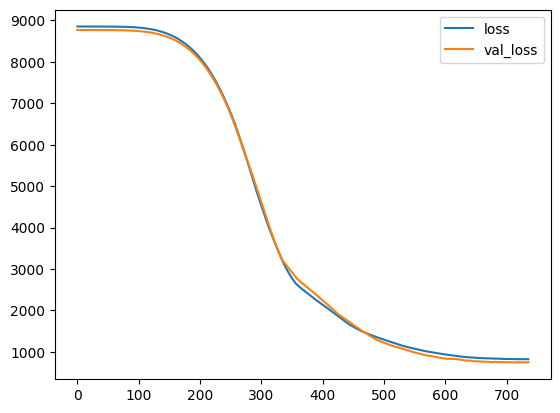

In [231]:
pd.DataFrame(model.history.history).plot()

count       16.00000
mean      8767.12500
std       8785.06522
min          0.00000
25%       2401.75000
50%       6040.50000
75%      14123.75000
max      29094.00000
Name: G3Dmark, dtype: float64 
 count       80.000000
mean      8852.662500
std       7276.841395
min          0.000000
25%       3351.000000
50%       6998.500000
75%      13843.000000
max      26887.000000
Name: G3Dmark, dtype: float64


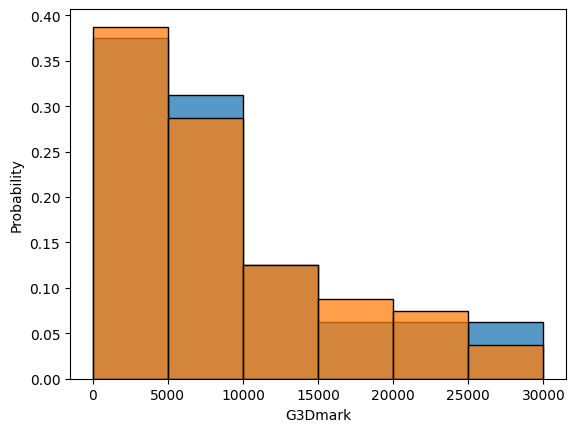

In [233]:
sns.histplot(y_test,binwidth=5000,stat="probability")
sns.histplot(y_train,binwidth=5000,stat="probability")
a=y_test.describe()
b=y_train.describe()
print(a,"\n",b)

1/1 [==============================] - 0s 14ms/step


<Axes: ylabel='G3Dmark'>

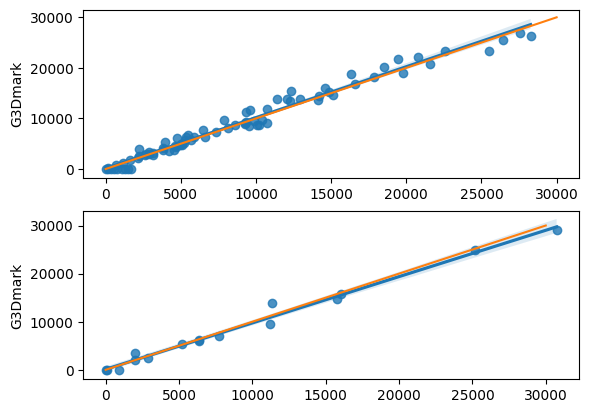

In [234]:
fig, axs = plt.subplots(2,1)
sns.regplot(x=model.predict(x_train),y=y_train,ax=axs[0])
sns.lineplot(x=list(range(30000)),y=list(range(30000)),ax=axs[0])
sns.regplot(x=model.predict(x_test),y=y_test,ax=axs[1])
sns.lineplot(x=list(range(30000)),y=list(range(30000)),ax=axs[1])

Let's see if our model can give reasonable outputs given a range of real world inputs not present on the dataset:

(I have used my RX 6700 10GB as a baseline, which is a less common model therefore not in the dataset)

 152/1407 [==>...........................] - ETA: 1s

C:\Users\Mete Kaan\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1407/1407 [==============================] - 1s 1ms/step


<Axes: >

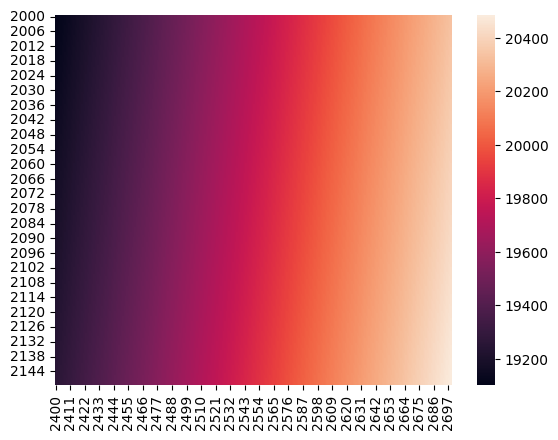

In [235]:
values = [[[i*2304*2/1000000, i*144/1000, i*64/1000, j*320/2000,9] for i in range(2400,2700)] for j in range (2000,2150)]
values = np.array(values).reshape(-1,5)
values = mmscale.transform(values)
result = model.predict(values)
result = result.reshape(150,300)

result = pd.DataFrame(result)
result.index = range(2000,2150)
result.columns = range(2400,2700)
sns.heatmap(result)

Now for an unreasonable test using values you're not likely to encounter in the real world:

We keep the Shader count fixed, and test for different TMU and ROP values

100/295 [=========>....................] - ETA: 0s

C:\Users\Mete Kaan\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


295/295 [==============================] - 0s 1ms/step


<Axes: >

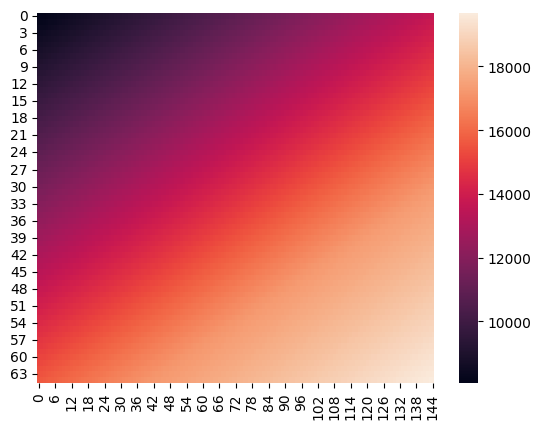

In [236]:
values = [[[2500*2304*2/1000000, 2500*i/1000, 2500*j/1000, 2150*320/2000,9] for i in range(0,145)] for j in range (0,65)]
values = np.array(values).reshape(-1,5)
values = mmscale.transform(values)
result = model.predict(values)
result = result.reshape(65,145)

sns.heatmap(result)

As expected, our performance drops significantly when we reduce either the TMU or the ROP count.

Now, let's see what happens if we input all zeros to the model:

In [237]:
values = [[0,0,0,0,i] for i in range(12)] #We only iterate over the architecture variable, the rest are 0
values = mmscale.transform(values)
model.predict(values)

1/1 [==============================] - 0s 15ms/step


C:\Users\Mete Kaan\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


array([[  37.357307],
       [  37.357307],
       [  84.82355 ],
       [ 182.60577 ],
       [ 358.04764 ],
       [ 545.5051  ],
       [ 732.96234 ],
       [ 920.4195  ],
       [1107.8765  ],
       [1295.3334  ],
       [1482.7903  ],
       [1670.2477  ]], dtype=float32)